In [41]:
# import modules
import torch
# torch.nn has most functions, torch.optim has optimizers
from torch import nn, optim
#torch.nn.functional also has functions. I'm not sure how it's diff from just torch.nn
import torch.nn.functional as F

# torchvision has datasets (from real world) so you can just import from here
from torchvision import datasets, transforms

# to graph your losses and data (if they're that kind of data)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

**The difference between torch.nn and torch.nn.functional is that the functional functions support an *input*! Which is probably why they're called functional - they operate as functions.**

You might want to normalize the data. I think it's just to make sure it's all the same "volumes", brightnesses, etc, but I'm not totally sure about why.

In [42]:
# Define a transform to normalize data
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [43]:
# download the data. Separate if you're training and testing.
trainingset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainingset, batch_size=64, shuffle=True)

# this says to download, for training, use the transform
# and trainloader is an iterator: for trainingset, batch size, and shuffle the data rather than giving it straight

In [44]:
# here's the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Create a model or a **Network**. There are many ways to do this!! And it depends on what you want to do.

For now, we've only looked at **Linear** boundaries. But each **Linear** function can goes through an **activation function**, such as Softmax, Sigmoid, ReLU, Log of Softmax, etc.

In [45]:
# define the class/network and import nn.Module so that it copies much of its stuff... (I'm not super clear on classes.)
class Network(nn.Module):
    # initialize - what you want to happen automatically when you create a new instance (with no added info per instance)
    def __init__(self):
        # I don't actually know what this line does...
        # MDN says it's used to call upon the constructor's parent. Can be used to prevent duplicating between constructors?
        super().__init__()
        # this is where you lay out the architecture of this network. 
        # Here, we're making 3 hidden layers of sizes 256, 128 and 64.
        # Our inputs have a size of 784 (our imagees are 28x28 and we'll flatten them to 784)
        # We want 10 outputs: one for each classification.
        self.layer1 = nn.Linear(784, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
        
        # if you want to add a dropout, do it here
        # p=0.2 means a probability of a node being dropped (during training) is 20%
        self.dropout = nn.Dropout(p=0.2)
        
    # a method that we'll be able to call on our instances. Note when we call it we need an input imgs
    def forward(self, imgs):
        # flatten our input images
        imgs = imgs.view(imgs.shape[0], -1)
        
        # each linear layer goes through a ReLU activation, except the last which is log_softmax
        imgs = self.dropout(F.relu(self.layer1(imgs)))
        imgs = self.dropout(F.relu(self.layer2(imgs)))
        imgs = self.dropout(F.relu(self.layer3(imgs)))
        
        # the dim=1 is to tell it to calculate across the columns: so each row will add up to 1.
        imgs = F.log_softmax(self.layer4(imgs), dim=1)
        
        return imgs

Everything is predefined now. It might be a good idea to put the following into functions, but I won't... for now.

Okay. I'll define some of them.

In [66]:
# One forward pass, as a function
def train_me():
    running_loss = 0

    # for each batch or mini batch of data
    for images, labels in trainloader:
        
        # reset the optimizer's memory to 0
        optimizer.zero_grad()
        
        # get the output of the model & calculate the loss
        log_probabilities = model(images)
        loss = criterion(log_probabilities, labels)
        
        # backpropagate with the loss and update the weights
        loss.backward()
        optimizer.step()
        
        # accumulate losses
        running_loss += loss
        
    return running_loss

In [67]:
# one validation pass, as a function
def validate_me():
    running_loss = 0
    accuracy = 0
    
    # switch to evaluation mode - turn off the dropout
    model.eval()
    
    # turn off the gradient memory, mainly for speed
    with torch.no_grad():
        
        # for each batch of test data
        for images, labels in testloader:
            
            # get the log probabilities (from log-softmax) and the loss
            log_probs = model(images)
            loss = criterion(log_probs, labels)
            
            # get the actual probabilities: I don't know why, but when using log_softmax it's the logs of the probabilities
            # but here, we want the ACTUAL probabilities. To do this, we exponentialize the log probabilities
            ps = torch.exp(log_probs)
            
            # Here, we want to test the probabilities. The network SHOULD be classifying our data into the 10 outputs.
            # So we take the 1 highest output for each image and compare it to the label.
            _,top_result = ps.topk(1)
            
            # we create a binary tensor of whether it's right or wrong.
            equals = top_result == labels.view(*top_result.shape)
            
            # We need to change the data types to floats, then take the mean, then make it a %.
            acc = torch.mean(equals.type(torch.FloatTensor))
            
            # accumulate losses and accuracies
            running_loss += loss
            accuracy += acc
            
    # remember to switch back to training mode!
    model.train()
    
    return running_loss, accuracy

In [68]:
# plot the training vs test losses
def plot_me(training, testing, accuracy):
    plt.plot(training, label="Training loss")
    plt.plot(testing, label="Validation loss")
    plt.plot(accuracy, label="Accuracy")
    plt.legend(frameon=False)

In [69]:
# Instantiate a model
model = Network()

# check it out! It just tells you what you've put in.
model

Network(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [70]:
# We also want to define our loss function (criterion) and optimizer.

# We use this loss function because we will be running it on log-softmax. They go hand in hand for some reason...
criterion = nn.NLLLoss()

# The Adam optimizer is apparently really great for using Momentum,
# which automatically adjusts the size of the gradient descent steps.

# lr is the learning rate
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [71]:
# Also, define how long to run (in this case, number of epochs)
epochs = 20

# Optionally, initialize the steps and train/test losses if you want to keep track of these
steps = 0
training_losses, test_losses = [], []
accs = []

We'll loop through the training data to train it.

In [72]:
for e in range(epochs):
    
    training_loss = train_me()
    test_loss, accuracy = validate_me()
    
    # troubleshoot
#     print(type(training_loss), type(test_loss), type(accuracy))
    
    print("Epoch {}  |  Training loss: {:.3f}  |  Test loss: {:.3f}  |  Accuracy: {:.3f}%".format(
        e,
        training_loss/len(trainloader),
        test_loss/len(testloader),
        (accuracy/len(testloader))*100))
    
    training_losses.append(training_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    accs.append(accuracy/len(testloader))

Epoch 0  |  Training loss: 4.186  |  Test loss: 2.309  |  Accuracy: 9.982%
Epoch 1  |  Training loss: 2.457  |  Test loss: 2.316  |  Accuracy: 10.012%
Epoch 2  |  Training loss: 2.366  |  Test loss: 2.312  |  Accuracy: 9.982%
Epoch 3  |  Training loss: 3.805  |  Test loss: 2.312  |  Accuracy: 10.042%
Epoch 4  |  Training loss: 2.548  |  Test loss: 2.310  |  Accuracy: 10.072%
Epoch 5  |  Training loss: 2.311  |  Test loss: 2.310  |  Accuracy: 10.012%
Epoch 6  |  Training loss: 5.089  |  Test loss: 2.308  |  Accuracy: 9.982%
Epoch 7  |  Training loss: 4.462  |  Test loss: 2.309  |  Accuracy: 9.952%
Epoch 8  |  Training loss: 2.799  |  Test loss: 2.312  |  Accuracy: 9.952%
Epoch 9  |  Training loss: 2.312  |  Test loss: 2.309  |  Accuracy: 10.012%
Epoch 10  |  Training loss: 7.460  |  Test loss: 2.318  |  Accuracy: 9.982%
Epoch 11  |  Training loss: 7.531  |  Test loss: 2.311  |  Accuracy: 10.012%
Epoch 12  |  Training loss: 4.606  |  Test loss: 2.308  |  Accuracy: 9.952%
Epoch 13  |  Tra

20
20


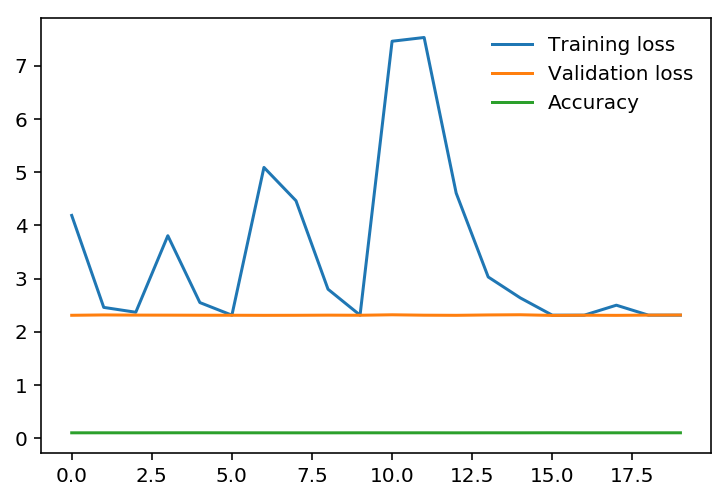

In [73]:
print(len(training_losses))
print(len(test_losses))
plot_me(training_losses, test_losses, accs)